### evaluate a pit model by draw prediction visually for a long horizon

MLP-pitmodel-v4


base: 11./evaluate_model_visualdraw

+ visualization of pitagemodel



In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import mxnet as mx
from mxnet import gluon
import pickle
import json
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.trainer import Trainer
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput
from gluonts.model.predictor import Predictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.r_forecast import RForecastPredictor
from indycar.model.NaivePredictor import NaivePredictor
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import indycar.model.evaluate_fulltest_fastrun_paper as ev

INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU


## Load Data

In [2]:
import os
os.getcwd()

'/scratch_hdd/hpda/indycar/notebook/22.PaperFinal'

#### evaluate

In [3]:
# construct long prediction result
def plot_prob_forecasts_ex(ts_entry, forecast_entry, outputfile):

    plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    #plot_length = forecast_entry[0].samples.shape[1] + 10 
    
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    figcnt = len(ts_entry)
    for idx in range(figcnt):
        fig, axs = plt.subplots(1, 1, figsize=(20, 7))
        
        
        
        #ts_entry[idx][-plot_length:].plot(ax=axs)  # plot the time series
        #forecast_entry[idx].plot(prediction_intervals=prediction_intervals, color='g')
        ts_entry[idx].iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
        

        #axs.set_xlim((80,110))
        
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        
        if outputfile != '':
            plt.savefig(outputfile + '-%d.pdf'%idx)
        
        # set the x ticks
        #xtickslocs = plt.gca().get_xticks()
        #print(xtickslocs)
        #ticks = [tick for tick in plt.gca().get_xticklabels()]
        #print(ticks)        
        
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 10)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x) for x in offset]
        plt.xticks(new_locs, new_labels)
        
        
        
        
        plt.show()
        


In [4]:
import pickle
def savedata(datafile,dfs):
    with open(datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = dfs
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)
        
def loaddata(datafile):
    with open(datafile, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        dfout = pickle.load(f, encoding='latin1') 
        return dfout        

In [16]:
def long_predict_bymloutput(output, dfin):
    """
    input:
        test_ds
        predictor
    
    """
    def get_start(idx):
        td = forecasts[idx].start_date - start_time
        return td.days*24*60 + td.seconds//60
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    start_time, row = next(tss[0].iterrows())

    first_start = get_start(-1)
    last_start = get_start(0)
    print('first start:', first_start, 'last start:', last_start)    
    
    import copy
    target = copy.deepcopy(forecasts[-1])

    #100, 10
    nsample, npredict = target.samples.shape
    print('sampel# x predictlen: ', nsample, npredict)
    
    newsamples = np.zeros((nsample, last_start - first_start + npredict))
    
    for idx in range(len(forecasts)):
        #copy samples
        start_pos = get_start(idx)

        pos = start_pos - first_start + 1
        #copy sample to block
        #newsamples[:, pos:pos + npredict] = forecasts[idx].samples
        #newsamples[:, pos + npredict - 1] = forecasts[idx].samples[:,-1]
        
        # get prediction from ml output
        # pos = laps
        # 1 ... 10 | 11 <- start pos in forecasts
        # 0 ...  9 | 10 <- 9 is the startlap
        #
        startlap = start_pos  - 2
        #print('start pos:', start_pos, 'pos:',pos, 'startlap:', startlap)
        
        _rec = dfin[dfin['startlap']== startlap]
        if len(_rec) > 0:
            # rank start from 1 for visualization
            pred_val = _rec.pred_endrank.values[0]
            
            #pred_val = _rec.pred_endrank.values
            #make sure shape match, 100 samples
            
            #newsamples[:, pos + npredict - 1] = pred_val + 1
            newsamples[:, pos] = pred_val + 1
            #print('startlap:', startlap, 'predrank:', pred_val)

    target.samples = newsamples
    
    print('target samples:', target.samples.shape)

    #plot_prob_forecasts_ex([tss[0]],[target],output)
    
    return target,tss[0]

In [5]:
# construct long prediction result


def plot_forecasts_h(ts_entry, forecast_entry, outputfile, 
                   colors = ['r','g','m'],
                   plabels= ['observed','svr','arima','ranknet']):

    plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    #plot_length = forecast_entry[0].samples.shape[1] + 10 
    
    #prediction_intervals = (50.0, 90.0)
    prediction_intervals = [90.0]
    
    #legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    figcnt = len(forecast_entry)
    
    #fig, axs = plt.subplots(figcnt,1, figsize=(8,6))
    fig, axs = plt.subplots(1, figcnt, figsize=(12,3*figcnt))

    #colors = ['r','g','m']
    #plabels = ['observed','svr','arima','ranknet']
    
    for idx in range(figcnt):
        ax = plt.subplot(figcnt, 1, idx+1)
        #ax = plt.subplot(1, figcnt, idx+1)
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs[idx], linewidth=1)  # plot the time series
        ts_entry.iloc[-plot_length:,0].plot(linewidth=1, color='b',
                                            marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 
    
    #for idx in range(len(forecast_entry)):
    #    forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
    
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                             color=colors[idx],label=plabels[idx+1], zorder=10)
        #forecast_entry[1].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='b')
        #forecast_entry[2].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='r')
        
        ax.set_xlabel('Lap')
        if idx==0:
            ax.set_ylabel('Rank')
    
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 5)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x) for x in offset]
        plt.xticks(new_locs, new_labels)

        #ax.set_xlim((80,110))
        ax.set_zorder(-1)
        plt.grid(which="both", zorder=-1)
        ax.set_axisbelow(True)
        
        l=plt.legend(prop={'size': 10},loc='upper left')
        l.set_zorder(0.6)
    
    plt.show()

    
    
def plot_forecasts(ts_entry, forecast_entry, outputfile, 
                   colors = ['r','g','m'],
                   plabels= ['observed','svr','arima','ranknet']):

    plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    #plot_length = forecast_entry[0].samples.shape[1] + 10 
    
    #prediction_intervals = (50.0, 90.0)
    prediction_intervals = [90.0]
    
    #legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    figcnt = len(forecast_entry)
    
    #fig, axs = plt.subplots(figcnt,1, figsize=(8,6))
    fig, axs = plt.subplots(1, figcnt, figsize=(4*figcnt,3))

    #colors = ['r','g','m']
    #plabels = ['observed','svr','arima','ranknet']
    
    for idx in range(figcnt):
        #ax = plt.subplot(figcnt, 1, idx+1)
        ax = plt.subplot(1, figcnt, idx+1)
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs[idx], linewidth=1)  # plot the time series
        ts_entry.iloc[-plot_length:,0].plot(linewidth=1, color='b',
                                            marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 
    
    #for idx in range(len(forecast_entry)):
    #    forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
    
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                             color=colors[idx],label=plabels[idx+1], zorder=10)
        #forecast_entry[1].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='b')
        #forecast_entry[2].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='r')
        
        ax.set_xlabel('Lap')
        if idx==0:
            ax.set_ylabel('Rank')
    
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 5)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x) for x in offset]
        plt.xticks(new_locs, new_labels)

        #ax.set_xlim((80,110))
        print('xlim:', plt.xlim())
        xl, xr = plt.xlim()
        ax.set_xlim((xl+80,xl+110))
        
        yb, yu = plt.ylim()
        print('ylim:', plt.ylim())
        ax.set_ylim((-5,+23))
        
        ax.set_zorder(-1)
        plt.grid(which="both", zorder=-1)
        ax.set_axisbelow(True)
        
        l=plt.legend(prop={'size': 10},loc='upper left')
        l.set_zorder(0.6)
    
    plt.show()
    fig.tight_layout()
    fig.savefig(outputfile + '-%d.pdf'%0)
    
def plot_forecast_singles(ts_entry, forecast_entry, outputfile, 
                   colors = ['r','g','m'],
                   plabels= ['observed','svr','arima','ranknet'],
                    xlim_l=80, xlim_h=110):

    plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    #plot_length = forecast_entry[0].samples.shape[1] + 10 
    
    #prediction_intervals = (50.0, 90.0)
    prediction_intervals = [90.0]
    
    #legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    figcnt = len(forecast_entry)
    
    #fig, axs = plt.subplots(figcnt,1, figsize=(8,6))
    #fig, axs = plt.subplots(1, figcnt, figsize=(4*figcnt,3))

    #colors = ['r','g','m']
    #plabels = ['observed','svr','arima','ranknet']
    
    for idx in range(figcnt):
        fig, axs = plt.subplots(1, 1, figsize=(4,3))
        #ax = plt.subplot(figcnt, 1, idx+1)
        ax = plt.subplot(1, 1, 1)
        
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs[idx], linewidth=1)  # plot the time series
        ts_entry.iloc[-plot_length:,0].plot(linewidth=1, color='b',
                                            marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 
    
    #for idx in range(len(forecast_entry)):
    #    forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
    
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                             color=colors[idx],label=plabels[idx+1], zorder=10)
        #forecast_entry[1].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='b')
        #forecast_entry[2].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='r')
        
        ax.set_xlabel('Lap')
        if idx==0:
            ax.set_ylabel('Rank')
    
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 5)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x+1) for x in offset]
        plt.xticks(new_locs, new_labels)

        #ax.set_xlim((80,110))
        print('xlim:', plt.xlim())
        xl, xr = plt.xlim()
        ax.set_xlim((xl+xlim_l,xl+xlim_h))
        #ax.set_xlim((xl+79,xl+109))
        
        yb, yu = plt.ylim()
        print('ylim:', plt.ylim())
        ax.set_ylim((-2,+26))
        
        ax.set_zorder(-1)
        plt.grid(which="both", zorder=-1)
        ax.set_axisbelow(True)
        
        l=plt.legend(prop={'size': 10},loc='upper left')
        l.set_zorder(0.6)
    
        plt.show()
        fig.tight_layout()
        fig.savefig(outputfile + '-%d.pdf'%(idx+1))    

### evaluate

In [6]:
#years = ['2013','2014','2015','2016','2017','2018','2019']
years = ['2013','2014','2015','2016','2017','2018']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}


In [7]:
prediction_length = 2
freq = '1min'

In [8]:
ev._dataset_id = 'indy2013-2018-nocarid'
ev._dataset_id = 'indy2013-2018'
#_test_event = 'Indy500-2019'
ev._test_event = 'Indy500-2018'

ev._task_id = 'rank'  # rank,laptime, the trained model's task
ev._run_ts = ev.COL_RANK   #COL_LAPTIME,COL_RANK
ev._exp_id='rank'  #rank, laptime, laptim2rank, timediff2rank... 

ev._feature_mode = ev.FEATURE_STATUS
ev._context_ratio = 0.

ev.init()

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/evaluate_fulltest_fastrun_paper.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/evaluate_fulltest_fastrun_paper.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


In [9]:
test_cars = [12]
save_prefix = 'test-' + ev._test_event + '_'.join([str(x) for x in test_cars])
outputfile = 'output'

In [10]:
train_ds, test_ds,_,_ = ev.make_dataset_byevent(events_id[ev._test_event], prediction_length,freq, 
                                     oracle_mode=ev.MODE_ORACLE,
                                     run_ts = ev._run_ts,
                                     test_event = ev._test_event,
                                     test_cars=test_cars,
                                     half_moving_win = 0,
                                     train_ratio = 0.4)


train len:0, test len:188, mae_track:0.0,mae_lap:0.0,


### load model from dfout

In [12]:
def load_dfout(datafile):
    #with open('laptime_rank_timediff_fulltest-oracle-%s.pickle'%year, 'rb') as f:
    with open(datafile, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        dfout = pickle.load(f, encoding='latin1') 
        
        return dfout[0]

In [13]:
### load ml models
_trim = 0
_include_final = True
_include_stintlen = True
#_include_stintlen = False
include_str = '1' if _include_final else '0'
stint_str = '1' if _include_stintlen else ''
outfile=f'shortterm-dfout-mlmodels-indy500-tr2013_2017-te2018_2019-end{include_str}-rerank-t{_trim}.pickle'
preddf = load_dfout(outfile)

outfile=f'shortterm-dfout-ranknet-indy500-tr2013_2017-te2018_2019-end{include_str}-normal-t{_trim}.pickle'
oracle_df = load_dfout(outfile)

#ranknet
outfile='../result/22.PaperFinal/shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-alldata.pickle'
#outfile='shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-alldata.pickle'
data = load_dfout(outfile)
ranknet_df, acc, ret = data

In [14]:
df = preddf['2018']['rf']
dfin = df[df['carno']==test_cars[0]]

In [15]:
dfin.head(2)

,carno,startlap,startrank,endrank,pred_endrank,diff,sign,pred_diff,pred_sign
7,12.0,9.0,2.0,2.0,12.0,0.0,0.0,10.0,1.0
40,12.0,10.0,2.0,2.0,12.0,0.0,0.0,10.0,1.0


In [17]:
len(dfin)

188

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/NaivePredictor.py:60: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start_date=start + target_len,


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)


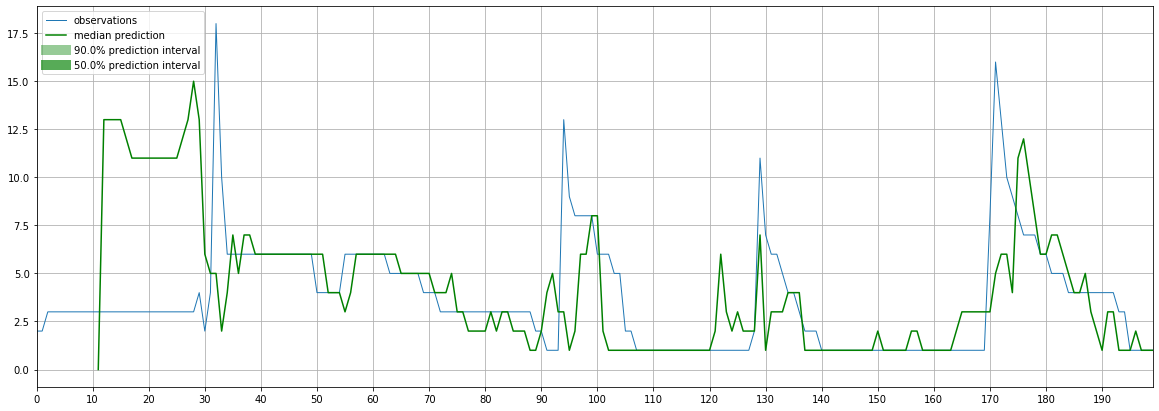

In [18]:
df = preddf['2018']['rf']
dfin = df[df['carno']==test_cars[0]]
predictor =  NaivePredictor(freq= freq, prediction_length = prediction_length)
target, tss = long_predict_bymloutput('', dfin)
plot_prob_forecasts_ex([tss],[target],'')

In [19]:
tss_template = tss

## PitModel dataset

In [310]:
from gluonts.model.forecast import SampleForecast
### pitmodel
class PitModel():
    """
     <caution_lap, pitage> -> [distribution]    
     distribution := sorted cdf [val:probability, val2:p2, ...]
         [0,:] -> val
         [1,:] -> cdf p
         
     no scaler, raw feat and target
    
    """
    def __init__(self, modelfile=''):
        self.model = {}
        self.name = ''
        
        if modelfile:
            self.load_model(modelfile)
                
    def load_model(self, modelfile):
        with open(modelfile, 'rb') as f:
            self.name, self.model = pickle.load(f, encoding='latin1')
            print(f'init model:{self.name}')
        
    def predict(self, *args):
        key = '-'.join([str(int(x)) for x in args])
        #if key in self.model:
        try:
            distr = self.model[key]
            
            #[0, 1.)
            p = np.random.random()  
            i = np.sum(distr[1,:] < p)
            
            return distr[0,i]
        except:
            #exception
            #todo, backto special model
            print(f'ERROR: key {key} not found in model')
            return 0
                       
    def forecast_ds(self, test_ds, sample_cnt=100):
        """
        test_ds as testset, the unsclaed input
        """
        
        totallen = len(test_ds)
        start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series

        #build a new forecasts object
        nf = []
        for idx, rec in enumerate(test_ds):
            
            feat = rec[1:]
                    
            onecast = np.zeros((sample_cnt))
            for i in range(sample_cnt):
                onecast[i] = self.predict(feat[0], feat[[1],feat[2]])
        
            nfc = SampleForecast(samples = onecast, 
                                 freq='1min', start_date=start)
            nf.append(nfc)

        return nf
    
    
    def forecast_onecar(self, test_ds, plen = 2, sample_cnt=100):
        """
        the probability of pitstop at plen laps
        long-prediction for a single car, 
        
        input:
            test_df ; 'lap2nextpit','caution_laps','pitage','lap'
        """
        
        #assert for one car
        totallen = len(test_ds)
        start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
        
        #samples
        #onecast = np.zeros((sample_cnt, totallen+plen))
        onecast = np.zeros((sample_cnt, totallen))
        #onecast = np.zeros((sample_cnt, maxlap))
        tss = np.zeros((totallen+plen))
        
        for idx, rec in enumerate(test_ds[:-plen]):
        #for idx in range(maxlap-plen):
            
            #if idx<len(test_ds):
            #    rec = test_ds[idx]
            #else:
            #    #use the last rec
            #    # target, cautionlaps, pitage, cur_curcautionlaps
            #    rec = [0, ] 
                
            target = rec[0]
            feat = rec[1:]
            
            if target == plen:
                tss[idx + plen] = 1
            
            for i in range(sample_cnt):
                nextpit = self.predict(*feat)
                                                    
                if nextpit == plen:
                    onecast[i, idx + plen] = 1
                
        forecast = SampleForecast(samples = onecast, 
                             freq='1min', start_date=start)

        return forecast, tss
    
    def forecast_onecar_range(self, test_ds, plen = 2, sample_cnt=100):
        """
        the probability of pitstop at plen laps
        long-prediction for a single car, 
        
        input:
            test_df ; 'lap2nextpit','caution_laps','pitage','lap'
        """
        
        #assert for one car
        totallen = len(test_ds)
        start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
        
        #samples
        #onecast = np.zeros((sample_cnt, totallen+plen))
        onecast = np.zeros((sample_cnt, totallen))
        #onecast = np.zeros((sample_cnt, maxlap))
        tss = np.zeros((totallen+plen))
        
        for idx, rec in enumerate(test_ds[:-plen]):
        #for idx in range(maxlap-plen):
            
            #if idx<len(test_ds):
            #    rec = test_ds[idx]
            #else:
            #    #use the last rec
            #    # target, cautionlaps, pitage, cur_curcautionlaps
            #    rec = [0, ] 
                
            target = rec[0]
            feat = rec[1:]
            
            if target == plen:
                tss[idx + plen] = 1
            
            for i in range(sample_cnt):
                nextpit = int(self.predict(*feat))
                                                    
                if nextpit <= plen:
                    onecast[i, idx + nextpit] = 1
                
        forecast = SampleForecast(samples = onecast, 
                             freq='1min', start_date=start)

        return forecast, tss    
    
    def forecast_onecar_lap2nextpit(self, test_ds, sample_cnt=100):
        """
        long-prediction for a single car
        
        input:
            test_df ; 'lap2nextpit','caution_laps','pitage','lap'
        """
        
        #assert for one car
        totallen = len(test_ds)
        start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
        
        #samples
        #onecast = np.zeros((sample_cnt, totallen+plen))
        onecast = np.zeros((sample_cnt, totallen))
        #onecast = np.zeros((sample_cnt, maxlap))
        tss = np.zeros((totallen))
        
        for idx, rec in enumerate(test_ds):
                
            target = rec[0]
            feat = rec[1:]
            
            tss[idx] = target
            
            for i in range(sample_cnt):
                nextpit = self.predict(*feat)
                onecast[i, idx] = nextpit
                
        forecast = SampleForecast(samples = onecast, 
                             freq='1min', start_date=start)

        return forecast, tss    

In [397]:
_inlap_status = 0
#years = ['2013','2014','2015','2016','2017','2018','2019']
years = ['2013','2014','2015','2016','2017','2018','2019']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}
dbid = f'Indy500_{years[0]}_{years[-1]}_v9_p{_inlap_status}'
testevent = 'Indy500-2018'
#datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}-alldata-withcurcautionlaps.pickle'
datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}-alldata-withcurcautionlaps-includeend.pickle'

df_train, df_test, events, testevent, _data = loaddata(datafile)
test_car12 = df_test[df_test['carno']==12]
test_ds = test_car12[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

In [131]:
prob, pit, fc, target, model = {}, {},{}, {}, {}


In [308]:
def get_predprob_by_model(modelfile, test_ds,plen=2, rangemode=False):
    pitmodel = PitModel()
    pitmodel.load_model(modelfile)
    
    if rangemode == True:
        forecast,targets = pitmodel.forecast_onecar_range(test_ds, plen=plen)
    else:
        forecast,targets = pitmodel.forecast_onecar(test_ds, plen=plen)
    
    

    #fill template
    tss = tss_template.copy()
    for idx in range(len(tss)):
        if idx < len(targets):
            tss.iloc[idx, 0] = targets[idx]
        else:
            tss.iloc[idx, 0] = 0

    #pred
    pred = np.mean(forecast.samples, axis=0)

    #pitstops
    pitidx = np.where(targets==1)
    pits = targets[pitidx]

    x = pitidx[0].reshape(-1)
    y = np.zeros_like(x)
    y = pred[x]
    pitstop = np.array([x+1,y])

    
    x = np.arange(len(pred)) + 1
    y = pred
    probability = np.array([x,y])
    
    return probability, pitstop, forecast, targets, pitmodel

In [305]:
allruns = ['sel','all','noshort']
for rid in allruns:
    prob[rid], pit[rid],fc[rid],target[rid],model[rid] = get_predprob_by_model(f'pitmodel-m65-mlp-d{rid}-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle', test_ds)
    

init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
init model:pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
init model:pitmodel-m65-mlp-dnoshort-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle


init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle


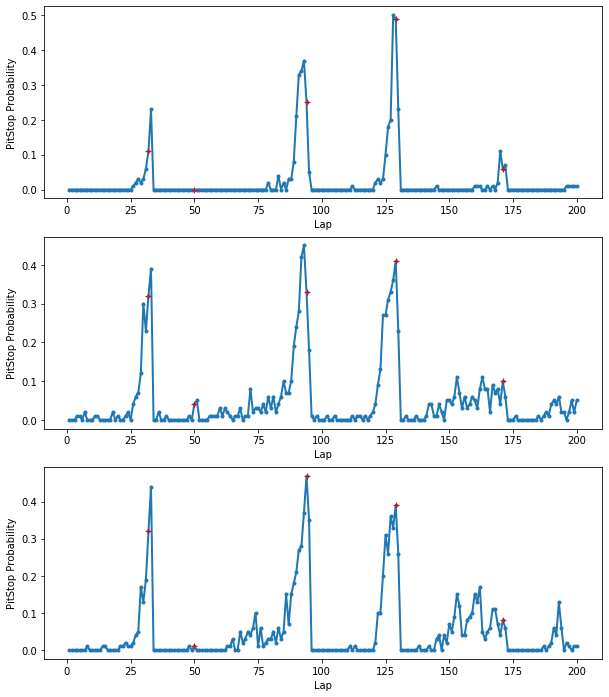

In [134]:
figcnt = len(allruns)
fig, axs = plt.subplots(figcnt, 1, figsize=(10, 4*figcnt))
for idx, rid in enumerate(allruns):
    axs[idx].plot(prob[rid][0,:],prob[rid][1,:],'.-',label='PitStop', linewidth=2)
    axs[idx].plot(pit[rid][0,:],pit[rid][1,:] ,'+',color='r', label='PitStopX', linewidth=2)
    axs[idx].set_ylabel('PitStop Probability')
    axs[idx].set_xlabel('Lap')

In [303]:
rid='dsel'
prob, pit, fc, target, model = {}, {},{}, {}, {}
prob[rid], pit[rid],fc[rid],target[rid],model[rid] = get_predprob_by_model(f'pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle', test_ds[:,:3],plen=6)

init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle


In [207]:
test_ds.shape

(167, 4)

In [218]:
rid='dsel'
fc[rid].samples[:,26]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [219]:
fc[rid].samples.shape

(100, 167)

In [221]:
np.where(fc[rid].samples[:,:]!=0)

(array([], dtype=int64), array([], dtype=int64))

In [222]:
np.sum(fc[rid].samples)

0.0

In [223]:
fc, ss = model[rid].forecast_onecar_lap2nextpit(test_ds[:,:3])

In [225]:
fc.samples[0,:]

array([28., 27., 26., 25., 24., 23., 22., 22., 21., 20., 19., 18., 17.,
       16., 15., 14., 14., 13., 12., 11., 11., 10.,  9.,  8.,  8.,  7.,
        6.,  5.,  5., 29., 28., 27., 26., 25., 24., 23., 22., 22., 21.,
       20., 19., 18., 17., 16., 15., 14., 14., 13., 12., 11., 11., 10.,
       10.,  9., 29., 29., 29., 29., 29., 28., 26., 25., 24., 23., 23.,
       22., 22., 22., 29., 29., 29., 28., 28., 28., 27., 25., 24., 23.,
       23., 22., 22., 21., 21., 20., 19., 18., 17., 16., 15., 14., 14.,
       13., 12., 11., 11., 10.,  9.,  8.,  8.,  7.,  6.,  6.,  5.,  4.,
       29., 28., 27., 26., 25., 24., 23., 22., 22., 21., 20., 19., 18.,
       17., 16., 15., 14., 14., 14., 14., 13., 13., 13., 12., 12., 11.,
       11., 10., 10.,  9.,  9.,  8.,  8.,  7., 29., 29., 29., 28., 27.,
       27., 27., 26., 25., 24., 23., 22., 22., 20., 19., 19., 18., 17.,
       16., 15., 14., 14., 13., 12., 11., 10., 10.,  9.,  9.])

In [228]:
rid

'dsel'

In [229]:
model[rid].model.keys()

dict_keys(['0-0', '0-1', '0-2', '0-3', '0-4', '0-5', '0-6', '0-7', '0-8', '0-9', '0-10', '0-11', '0-12', '0-13', '0-14', '0-15', '0-16', '0-17', '0-18', '0-19', '0-20', '0-21', '0-22', '0-23', '0-24', '0-25', '0-26', '0-27', '0-28', '0-29', '0-30', '0-31', '0-32', '0-33', '0-34', '0-35', '0-36', '0-37', '0-38', '0-39', '0-40', '0-41', '0-42', '0-43', '0-44', '0-45', '0-46', '0-47', '0-48', '0-49', '0-50', '0-51', '0-52', '0-53', '0-54', '0-55', '0-56', '0-57', '0-58', '0-59', '0-60', '0-61', '0-62', '0-63', '0-64', '1-1', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '1-10', '1-11', '1-12', '1-13', '1-14', '1-15', '1-16', '1-17', '1-18', '1-19', '1-20', '1-21', '1-22', '1-23', '1-24', '1-25', '1-26', '1-27', '1-28', '1-29', '1-30', '1-31', '1-32', '1-33', '1-34', '1-35', '1-36', '1-37', '1-38', '1-39', '1-40', '1-41', '1-42', '1-43', '1-44', '1-45', '1-46', '1-47', '1-48', '1-49', '1-50', '1-51', '1-52', '1-53', '1-54', '1-55', '1-56', '1-57', '1-58', '1-59', '1-60', '1-61', 

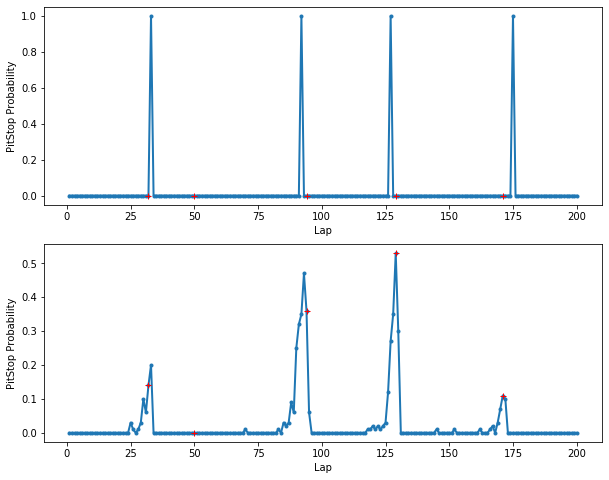

In [306]:
runs=['dsel','sel']
figcnt = len(runs)
fig, axs = plt.subplots(figcnt, 1, figsize=(10, 4*figcnt))
for idx, rid in enumerate(runs):
    axs[idx].plot(prob[rid][0,:],prob[rid][1,:],'.-',label='PitStop', linewidth=2)
    axs[idx].plot(pit[rid][0,:],pit[rid][1,:] ,'+',color='r', label='PitStopX', linewidth=2)
    axs[idx].set_ylabel('PitStop Probability')
    axs[idx].set_xlabel('Lap')

In [353]:
plen=2
rid='dsel-range'
prob[rid], pit[rid],fc[rid],target[rid],model[rid] = get_predprob_by_model(f'pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle', test_ds[:,:3],plen=plen, rangemode=True)

init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle


In [354]:
allruns = ['sel-range']
rrid = 'sel'
for rid in allruns:
    prob[rid], pit[rid],fc[rid],target[rid],model[rid] = get_predprob_by_model(f'pitmodel-m65-mlp-d{rrid}-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle', test_ds, plen=plen, rangemode=True)
    

init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle


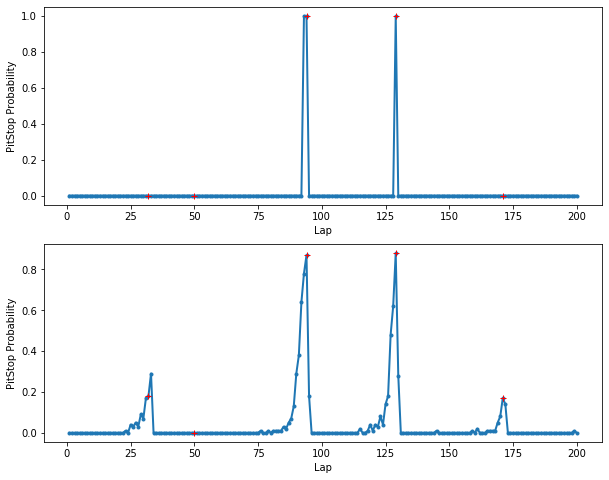

In [355]:
runs=['dsel-range','sel-range']
figcnt = len(runs)
fig, axs = plt.subplots(figcnt, 1, figsize=(10, 4*figcnt))
for idx, rid in enumerate(runs):
    axs[idx].plot(prob[rid][0,:],prob[rid][1,:],'.-',label='PitStop', linewidth=2)
    axs[idx].plot(pit[rid][0,:],pit[rid][1,:] ,'+',color='r', label='PitStopX', linewidth=2)
    axs[idx].set_ylabel('PitStop Probability')
    axs[idx].set_xlabel('Lap')

In [365]:
from sklearn.metrics import f1_score, recall_score

In [375]:
def get_f1(rid, threshold=0.5):
    pred_true = list(np.where(prob[rid][1,:] > threshold)[0])
    print(pred_true)
    truth = (pit[rid][0]-1).astype(int)
    print(truth)
    y_pred = [ 1 if x in pred_true else 0 for x in range(0,200)]
    y_true =[ 1 if x in truth else 0 for x in range(0,200)]
    f1 = f1_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred)
    
    print('f1:', f1, 'recall', recall)
    return f1, recall

init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle


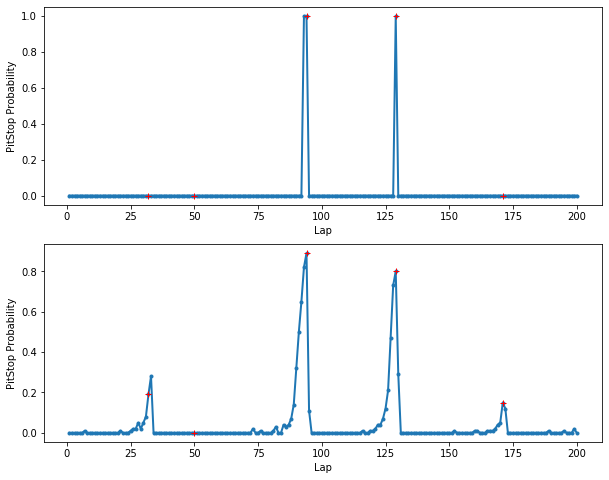

In [368]:
plen=2
rid='dsel-range'
prob[rid], pit[rid],fc[rid],target[rid],model[rid] = get_predprob_by_model(f'pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle', test_ds[:,:3],plen=plen, rangemode=True)
allruns = ['sel-range']
rrid = 'sel'
for rid in allruns:
    prob[rid], pit[rid],fc[rid],target[rid],model[rid] = get_predprob_by_model(f'pitmodel-m65-mlp-d{rrid}-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle', test_ds, plen=plen, rangemode=True)
runs=['dsel-range','sel-range']
figcnt = len(runs)
fig, axs = plt.subplots(figcnt, 1, figsize=(10, 4*figcnt))
for idx, rid in enumerate(runs):
    axs[idx].plot(prob[rid][0,:],prob[rid][1,:],'.-',label='PitStop', linewidth=2)
    axs[idx].plot(pit[rid][0,:],pit[rid][1,:] ,'+',color='r', label='PitStopX', linewidth=2)
    axs[idx].set_ylabel('PitStop Probability')
    axs[idx].set_xlabel('Lap')   


In [370]:
threshold=0.15
get_f1('dsel-range', threshold=threshold)
get_f1('sel-range', threshold=threshold)

[92, 93, 128]
[ 31  49  93 128 170]
f1: 0.7448979591836735 recall 0.4
[31, 32, 89, 90, 91, 92, 93, 125, 126, 127, 128, 129]
[ 31  49  93 128 170]
f1: 0.6621102749193672 recall 0.6


(0.6621102749193672, 0.6)

In [371]:
test_car12 = df_test[df_test['carno']==14]
test_ds = test_car12[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values


init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle


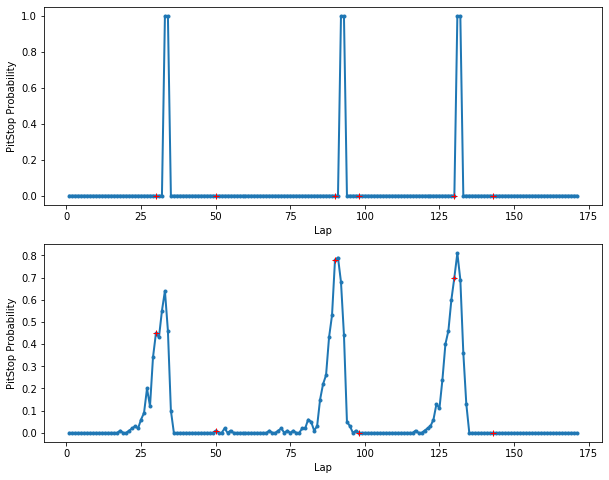

In [376]:
plen=6
rid='dsel-range'
prob[rid], pit[rid],fc[rid],target[rid],model[rid] = get_predprob_by_model(f'pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle', test_ds[:,:3],plen=plen, rangemode=True)
allruns = ['sel-range']
rrid = 'sel'
for rid in allruns:
    prob[rid], pit[rid],fc[rid],target[rid],model[rid] = get_predprob_by_model(f'pitmodel-m65-mlp-d{rrid}-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle', test_ds, plen=plen, rangemode=True)
runs=['dsel-range','sel-range']
figcnt = len(runs)
fig, axs = plt.subplots(figcnt, 1, figsize=(10, 4*figcnt))
for idx, rid in enumerate(runs):
    axs[idx].plot(prob[rid][0,:],prob[rid][1,:],'.-',label='PitStop', linewidth=2)
    axs[idx].plot(pit[rid][0,:],pit[rid][1,:] ,'+',color='r', label='PitStopX', linewidth=2)
    axs[idx].set_ylabel('PitStop Probability')
    axs[idx].set_xlabel('Lap')  

In [377]:
threshold=0.15
get_f1('dsel-range', threshold=threshold)
get_f1('sel-range', threshold=threshold)

[32, 33, 91, 92, 130, 131]
[ 29  49  89  97 129 142]
f1: 0.4845360824742268 recall 0.0
[26, 28, 29, 30, 31, 32, 33, 85, 86, 87, 88, 89, 90, 91, 92, 125, 126, 127, 128, 129, 130, 131, 132]
[ 29  49  89  97 129 142]
f1: 0.5724509712798588 recall 0.5


(0.5724509712798588, 0.5)

In [444]:
def get_predprob_by_pitmodel(pitmodel, test_ds,plen=2, rangemode=False):
    
    if rangemode == True:
        forecast,targets = pitmodel.forecast_onecar_range(test_ds, plen=plen)
    else:
        forecast,targets = pitmodel.forecast_onecar(test_ds, plen=plen)

    #fill template
    tss = tss_template.copy()
    for idx in range(len(tss)):
        if idx < len(targets):
            tss.iloc[idx, 0] = targets[idx]
        else:
            tss.iloc[idx, 0] = 0

    #pred
    pred = np.mean(forecast.samples, axis=0)

    #pitstops
    pitidx = np.where(targets==1)
    pits = targets[pitidx]

    x = pitidx[0].reshape(-1)
    y = np.zeros_like(x)
    y = pred[x]
    pitstop = np.array([x+1,y])

    
    x = np.arange(len(pred)) + 1
    y = pred
    probability = np.array([x,y])
    
    return probability, pitstop, forecast, targets, pitmodel

def get_macro_eval(modelfile, featureCnt, plen=2, threshold=0.5, rangemode=True, datamode='all'):
    pitmodel = PitModel()
    pitmodel.load_model(modelfile)
    
    carlist = set(list(df_test.carno.values))

    ret = []
    for carno in carlist:
        
        if datamode == 'normal':
            #use normal pit only
            test_car12 = df_test[(df_test['carno']==carno) & (df_test['pit_oncaution']==0)]
        elif datamode == 'sel':
            #use normal pit only
            test_car12 = df_test[(df_test['carno']==carno) & (df_test['pit_oncaution']==0) & (df_test['stint_len']>23)]
        elif datamode == 'shortnormal':
            test_car12 = df_test[(df_test['carno']==carno) & (df_test['pit_oncaution']==0) & (df_test['stint_len']<=23)]
        elif datamode == 'caution':
            #use normal pit only
            test_car12 = df_test[(df_test['carno']==carno) & (df_test['pit_oncaution']==1)]
        else:
            test_car12 = df_test[df_test['carno']==carno]
        
        test_ds = test_car12[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

        prob, pit,fc,target,model = get_predprob_by_pitmodel(
            pitmodel, test_ds[:,:featureCnt+1],plen=plen, rangemode=rangemode)

        pred_true = list(np.where(prob[1,:] > threshold)[0])
        print(pred_true)
        truth = (pit[0]-1).astype(int)
        print(truth)
        y_pred = [ 1 if x in pred_true else 0 for x in range(0,200)]
        y_true =[ 1 if x in truth else 0 for x in range(0,200)]
        #f1 = f1_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='binary')
        recall = recall_score(y_true, y_pred)
    
        print('f1:', f1, 'recall', recall)
        ret.append([f1, recall])
        
    #macro mean
    macro_ret = np.mean(np.array(ret), axis=0)
    print('macro ret:', macro_ret)
    
    return ret, macro_ret

In [446]:
cols = ['model','featureCnt','datamode', 'plen','f1','recall']
reteval = []
plen = 2
threshold = 0.15

for feature_cnt in [2,3]:
    for datamode in ['all','sel','shortnormal','caution']:
        #paper output
        _, ret = get_macro_eval(f'pitmodel-m65-mlp-dsel-f{feature_cnt}-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle', 
                                feature_cnt, plen=plen, threshold=threshold, datamode = datamode)
        reteval.append(['mlp-sel',feature_cnt,datamode, plen, ret[0], ret[1]])
        _, ret = get_macro_eval(f'pitmodel-m65-mlp-dall-f{feature_cnt}-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle', 
                                feature_cnt, plen=plen, threshold=threshold, datamode = datamode)
        reteval.append(['mlp-all',feature_cnt, datamode,plen, ret[0], ret[1]])
        _, ret = get_macro_eval(f'pitmodel-m65-dmlp-dsel-f{feature_cnt}-e500-l10-10-5-1-student-d0.1-1k.pickle', 
                                feature_cnt,plen=plen, datamode = datamode)
        reteval.append(['dmlp-sel',feature_cnt, datamode,plen, ret[0], ret[1]])
        _, ret = get_macro_eval(f'pitmodel-m65-dmlp-dall-f{feature_cnt}-e500-l10-10-5-1-student-d0.1-1k.pickle', 
                                feature_cnt,plen=plen, datamode = datamode)
        reteval.append(['dmlp-all',feature_cnt, datamode,plen, ret[0], ret[1]])

evaldf_result = pd.DataFrame(data=reteval, columns=cols) 
                

init model:pitmodel-m65-mlp-dsel-f2-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
[30, 31, 32, 132, 133, 134, 135]
[ 31  49  69 100 134 169]
f1: 0.30769230769230765 recall 0.3333333333333333
[89, 90, 91, 92, 93, 125, 126, 127, 128]
[ 30  49  93 127]
f1: 0.30769230769230765 recall 0.5
[31, 32, 33, 89, 90, 91, 92, 93, 123, 124, 125, 126, 127, 172]
[ 32  49  92 126 171]
f1: 0.3157894736842105 recall 0.6
[31, 32, 33, 102, 103, 104, 105, 106, 137]
[ 32  49  69 105 136 179 190]
f1: 0.25 recall 0.2857142857142857
[31, 32, 33, 34, 35, 178, 179, 180]
[ 35  52  59  88  95 106 119 137 179]
f1: 0.23529411764705882 recall 0.2222222222222222
[31, 32, 89, 90, 91, 92, 93, 94, 126, 127, 128, 129, 130, 194, 195, 196, 197, 198, 199]
[ 31  49  94 129 159]
f1: 0.25 recall 0.6
[31, 32, 33, 34]
[33]
f1: 0.4 recall 1.0
[31, 32, 89, 90, 91, 92, 93, 125, 126, 127, 128, 129]
[ 31  49  93 128 170]
f1: 0.35294117647058826 recall 0.6
[]
[28]
f1: 0.0 recall 0.0
[90, 129, 130]
[ 29  49  89  97 129 142]
f1: 

[92, 94, 95, 96, 97, 129, 130, 131]
[31 49 96]
f1: 0.18181818181818182 recall 0.3333333333333333
[32, 33, 34, 104, 105, 106, 107, 108, 179, 189, 190, 191, 192, 193, 194, 195]
[ 33  69 107 140 151]
f1: 0.19047619047619047 recall 0.4
[124, 125, 126, 127]
[ 30  49  91 126 172]
f1: 0.22222222222222224 recall 0.2
[33, 34, 92, 129]
[ 33  49  93  95 128 176 189]
f1: 0.18181818181818182 recall 0.14285714285714285
[125, 126, 127, 128]
[ 30  49  92 127 174]
f1: 0.22222222222222224 recall 0.2
[]
[ 30  49  90 120 140 156 159 194]
f1: 0.0 recall 0.0
[93]
[31 49 92]
f1: 0.0 recall 0.0
[33, 34, 104, 105, 106, 136, 138, 139, 140, 141, 193, 194, 195, 196]
[ 33  49  69 105 140 156 195]
f1: 0.38095238095238093 recall 0.5714285714285714
[]
[ 30  52  69 100 133 149 155 179]
f1: 0.0 recall 0.0
[32, 33, 34, 94, 95, 127, 128, 129, 130]
[ 33  49  94 129 173]
f1: 0.42857142857142855 recall 0.6
[32, 93, 126, 127, 128, 129, 130]
[ 31  49  93 129 171]
f1: 0.3333333333333333 recall 0.4
[32, 33, 34, 103, 104, 105, 1

[32, 33, 34, 179, 180]
[ 35  52  59  88  95 106 119 137 179]
f1: 0.14285714285714285 recall 0.1111111111111111
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not foun

ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found i

[32, 90, 91, 92, 93, 94, 95, 129, 130]
[31 49 96]
f1: 0.0 recall 0.0
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not found in model
ERROR: key 2-36 not f

[90, 91, 124, 125, 126, 171, 172]
[ 30  49  91 126 172]
f1: 0.5 recall 0.6
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not foun

[32, 33, 90, 91, 92, 93, 127, 128, 129, 174]
[ 33  49  94 129 173]
f1: 0.26666666666666666 recall 0.4
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in mode

[32, 33, 91, 92, 93, 94, 128, 129, 130, 194, 195]
[ 33  52  95 130 157 195]
f1: 0.3529411764705882 recall 0.5
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found

[32, 33, 103, 104, 136]
[ 32  52  69 103 135 167]
f1: 0.3636363636363636 recall 0.3333333333333333
[32]
[ 31  49  59  92 123 140 170 190]
f1: 0.0 recall 0.0
[32, 90, 91, 124, 125, 169, 170]
[ 31  49  91 124 169]
f1: 0.5 recall 0.6
macro ret: [0.25659059 0.30359623]
init model:pitmodel-m65-dmlp-dall-f2-e500-l10-10-5-1-student-d0.1-1k.pickle
[]
[ 31  49  69 100 134 169]
f1: 0.0 recall 0.0
[]
[ 30  49  93 127]
f1: 0.0 recall 0.0
[]
[ 32  49  92 126 171]
f1: 0.0 recall 0.0
[]
[ 32  49  69 105 136 179 190]
f1: 0.0 recall 0.0
[]
[ 35  52  59  88  95 106 119 137 179]
f1: 0.0 recall 0.0
[]
[ 31  49  94 129 159]
f1: 0.0 recall 0.0
[]
[33]
f1: 0.0 recall 0.0
[]
[ 31  49  93 128 170]
f1: 0.0 recall 0.0
[]
[28]
f1: 0.0 recall 0.0
[]
[ 29  49  89  97 129 142]
f1: 0.0 recall 0.0
[]
[ 34  49  69 105 137 172]
f1: 0.0 recall 0.0
[]
[ 33  52  69 102 135 139 141 186]
f1: 0.0 recall 0.0
[]
[31 49 96]
f1: 0.0 recall 0.0
[]
[ 33  69 107 140 151]
f1: 0.0 recall 0.0
[]
[ 30  49  91 126 172]
f1: 0.0 recall 0.0

[32, 33, 73, 74, 75, 108, 109]
[ 32  75 109]
f1: 0.6 recall 1.0
[32, 33, 66, 67, 68]
[32 68 99]
f1: 0.5 recall 0.6666666666666666
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in m

ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found i

f1: 0.33333333333333337 recall 1.0
[71, 72, 105, 106, 107, 152]
[ 30  72 107]
f1: 0.4444444444444444 recall 0.6666666666666666
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: ke

ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found i

ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found in model
ERROR: key 11-41 not found i

[]
[ 33  78 113]
f1: 0.0 recall 0.0
[]
[ 31  75 111]
f1: 0.0 recall 0.0
[]
[33 69]
f1: 0.0 recall 0.0
[]
[33]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[29 65]
f1: 0.0 recall 0.0
[]
[ 33  76 111]
f1: 0.0 recall 0.0
[]
[ 33  76 111]
f1: 0.0 recall 0.0
[]
[32 66 98]
f1: 0.0 recall 0.0
[]
[31 64 95]
f1: 0.0 recall 0.0
[]
[ 31  73 106]
f1: 0.0 recall 0.0
macro ret: [0. 0.]
init model:pitmodel-m65-mlp-dsel-f2-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[ 7 18 31]
f1: 0.0 recall 0.0
[36, 37, 38, 39, 40]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[8]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[32, 33, 34, 35]
[]
f1: 0.0 recall 0.0
[35, 36, 37, 38, 39, 40, 41, 42, 43]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[2]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]

[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
macro ret: [0. 0.]
init model:pitmodel-m65-dmlp-dall-f2-e500-l10-10-5-1-student-d0.1-1k.pickle
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[ 7 18 31]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[8]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[2]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall

[31]
[30]
f1: 0.0 recall 0.0
[96, 97, 98, 128]
[ 29  52  59  61  97 128 155 157 189]
f1: 0.30769230769230765 recall 0.2222222222222222
[31, 32, 33, 34, 90, 91, 92, 93, 94, 95, 127, 128, 129, 130, 131, 194, 195, 196]
[ 33  52  95 130 157 195]
f1: 0.3333333333333333 recall 0.6666666666666666
[31, 32, 33, 34, 91, 92, 93, 94, 95, 128, 129, 130, 131, 190, 193, 194, 195, 196]
[ 33  52  95 130 156 196]
f1: 0.3333333333333333 recall 0.6666666666666666
[31, 32, 33, 103, 104, 135, 136]
[ 32  52  69 103 135 167]
f1: 0.4615384615384615 recall 0.5
[31, 32, 124]
[ 31  49  59  92 123 140 170 190]
f1: 0.18181818181818182 recall 0.125
[31, 32, 90, 91, 92, 123, 124, 125, 169, 170]
[ 31  49  91 124 169]
f1: 0.5333333333333333 recall 0.8
macro ret: [0.29612064 0.47545883]
init model:pitmodel-m65-mlp-dall-f3-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
[29, 30, 31, 32, 130, 131, 132, 133, 134, 135]
[ 31  49  69 100 134 169]
f1: 0.25 recall 0.3333333333333333
[28, 29, 30, 85, 86, 87, 88, 89, 90, 

ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 1

ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 1

ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
E

[32, 33, 34, 179]
[ 35  52  59  88  95 106 119 137 179]
f1: 0.15384615384615383 recall 0.1111111111111111
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 n

ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-34-0 not found in model
E

ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
E

ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 1

[32, 90, 91, 92, 126, 127]
[ 31  49  93 128 170]
f1: 0.0 recall 0.0
[]
[28]
f1: 0.0 recall 0.0
[90, 130]
[ 29  49  89  97 129 142]
f1: 0.0 recall 0.0
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model

[32, 33, 103, 104, 138]
[ 34  49  69 105 137 172]
f1: 0.0 recall 0.0
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR:

ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 1

ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
E

[32, 103, 104, 105, 106, 140, 188, 189, 190, 191, 192, 193]
[ 33  69 107 140 151]
f1: 0.11764705882352941 recall 0.2
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in m

ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 20-46-0 not found in model
ERROR: key 2

[90, 91, 125, 126, 173]
[ 30  49  92 127 174]
f1: 0.0 recall 0.0
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key

ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 1

[133]
[ 30  52  69 100 133 149 155 179]
f1: 0.2222222222222222 recall 0.125
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model

ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
E

[32, 90, 91, 92, 126, 127, 128]
[ 31  49  93 129 171]
f1: 0.0 recall 0.0
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ER

ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
ERROR: key 6-37-0 not found in model
E

ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
E

ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
E

ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
E

[32, 103, 136]
[ 32  52  69 103 135 167]
f1: 0.4444444444444444 recall 0.3333333333333333
[32]
[ 31  49  59  92 123 140 170 190]
f1: 0.0 recall 0.0
[32, 90, 91, 124, 170]
[ 31  49  91 124 169]
f1: 0.4000000000000001 recall 0.4
macro ret: [0.09668895 0.08418899]
init model:pitmodel-m65-dmlp-dall-f3-e500-l10-10-5-1-student-d0.1-1k.pickle
[]
[ 31  49  69 100 134 169]
f1: 0.0 recall 0.0
[]
[ 30  49  93 127]
f1: 0.0 recall 0.0
[]
[ 32  49  92 126 171]
f1: 0.0 recall 0.0
[]
[ 32  49  69 105 136 179 190]
f1: 0.0 recall 0.0
[]
[ 35  52  59  88  95 106 119 137 179]
f1: 0.0 recall 0.0
[]
[ 31  49  94 129 159]
f1: 0.0 recall 0.0
[]
[33]
f1: 0.0 recall 0.0
[]
[ 31  49  93 128 170]
f1: 0.0 recall 0.0
[]
[28]
f1: 0.0 recall 0.0
[]
[ 29  49  89  97 129 142]
f1: 0.0 recall 0.0
[]
[ 34  49  69 105 137 172]
f1: 0.0 recall 0.0
[]
[ 33  52  69 102 135 139 141 186]
f1: 0.0 recall 0.0
[]
[31 49 96]
f1: 0.0 recall 0.0
[]
[ 33  69 107 140 151]
f1: 0.0 recall 0.0
[]
[ 30  49  91 126 172]
f1: 0.0 recall 0.0
[]


ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 14-43-0 not found in model
ERROR: key 1

ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
ERROR: key 2-35-0 not found in model
E

ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 1

[32]
[]
f1: 0.0 recall 0.0
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not 

[32, 72, 73, 74, 108, 109]
[ 31  75 110]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[70]
[29 69]
f1: 0.0 recall 0.0
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in m

[32, 33, 68, 69]
[34 70]
f1: 0.0 recall 0.0
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in 

[32, 67, 68]
[33]
f1: 0.0 recall 0.0
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
E

[32, 74, 75, 76, 110, 156]
[ 33  77 110]
f1: 0.2222222222222222 recall 0.3333333333333333
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in mode

[71, 72, 106, 107, 154]
[ 30  73 108]
f1: 0.0 recall 0.0
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 not found in model
ERROR: key 4-31-4 

ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
E

[94]
[30 61 94]
f1: 0.5 recall 0.3333333333333333
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not fou

[32, 74, 75, 76, 77, 111, 112]
[ 33  78 113]
f1: 0.0 recall 0.0
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not found in model
ERROR: key 14-42-0 not f

[32, 72, 73, 74, 108, 109, 110]
[ 31  75 111]
f1: 0.0 recall 0.0
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key

[]
[]
f1: 0.0 recall 0.0
[65]
[29 65]
f1: 0.6666666666666666 recall 0.5
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERR

[32, 72, 73, 74, 75, 109, 110, 144, 145, 148]
[ 33  76 111]
f1: 0.0 recall 0.0
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in mo

ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
ERROR: key 6-34-3 not found in model
E

[]
[ 30  72 107]
f1: 0.0 recall 0.0
[]
[ 33  77 110]
f1: 0.0 recall 0.0
[]
[ 30  73 108]
f1: 0.0 recall 0.0
[]
[ 30  71 101]
f1: 0.0 recall 0.0
[]
[31]
f1: 0.0 recall 0.0
[]
[33 69]
f1: 0.0 recall 0.0
[]
[30 61 94]
f1: 0.0 recall 0.0
[]
[ 33  78 113]
f1: 0.0 recall 0.0
[]
[ 31  75 111]
f1: 0.0 recall 0.0
[]
[33 69]
f1: 0.0 recall 0.0
[]
[33]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[29 65]
f1: 0.0 recall 0.0
[]
[ 33  76 111]
f1: 0.0 recall 0.0
[]
[ 33  76 111]
f1: 0.0 recall 0.0
[]
[32 66 98]
f1: 0.0 recall 0.0
[]
[31 64 95]
f1: 0.0 recall 0.0
[]
[ 31  73 106]
f1: 0.0 recall 0.0
macro ret: [0. 0.]
init model:pitmodel-m65-mlp-dsel-f3-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[ 7 18 31]
f1: 0.0 recall 0.0
[35, 36, 37, 38, 39, 40]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[8]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 re

[31, 32, 36, 37, 38]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[8]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found in model
ERROR: key 0-33-0 not found i

ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
ERROR: key 12-42-0 not found in model
[37, 38, 39, 40, 41, 42]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[2]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]


[69]
[36 69]
f1: 0.6666666666666666 recall 0.5
[]
[]
f1: 0.0 recall 0.0
[]
[16]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[19 39 55]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
ERROR: key 2-34-2 not found in model
ERROR: key 2-34-2 not found in model
ERROR: key 2-34-2 not found in model
ERROR: key 2-34-2 not found in model
ERROR: key 2-34-2 not found in model
ERROR: key 2-34-2 not found in model
ERROR: key 2-34-2 not found in model
ERROR: key 2-34-2 not found in model
ERROR: key 2-34-2 not found in model
ERROR: key 2-34-2 not found in model
ERROR: key 2-34-2 not found in model
ERROR: key 2-34-2 not found in model
ERROR: key 2-34-2 not found in model
ERROR: key 2-34-2 not found in model
ERROR: key 2-34-2 not found in model
ERROR: key 2-34-2 not found in model
ERROR: key 2-34-2 not found in model
ERROR: key 2-34-2 not found in model
ERROR: key 2-34-2 not found in model
ERROR: key 2-34-2 not found in model
ERROR: key 2-34-2 not found in model
ERROR: key 2-34-2 not found in model
ERRO

In [447]:
evaldf_result

,model,featureCnt,datamode,plen,f1,recall
0,mlp-sel,2,all,2,0.278625,0.462698
1,mlp-all,2,all,2,0.233602,0.288418
2,dmlp-sel,2,all,2,0.256591,0.303596
3,dmlp-all,2,all,2,0.000000,0.000000
4,mlp-sel,2,sel,2,0.312922,0.760417
5,mlp-all,2,sel,2,0.330645,0.520833
6,dmlp-sel,2,sel,2,0.273459,0.447917
7,dmlp-all,2,sel,2,0.000000,0.000000
8,mlp-sel,2,shortnormal,2,0.000000,0.000000
9,mlp-all,2,shortnormal,2,0.000000,0.000000


In [450]:
evaldf_result.to_csv('pitmodel_f1recall_evaluation_result_paper.csv')

## paper figure

In [135]:
# load stagedata and draw status
stagedata = loaddata(f'stagedata-{dbid}.pickle')

In [136]:
alldata, rankdata, acldata, flagdata = stagedata['Indy500-2018']
df12 = rankdata[rankdata['car_number']==12]
data = df12[['completed_laps','rank','last_laptime','time_behind_leader']].values
pitstop = df12[['lap_status']].values
caution = df12[['track_status']].values
pitstop = np.array([1 if x=='P' else 0 for x in pitstop])
caution = np.array([1 if x=='Y' else 0 for x in caution])
pitidx = np.where(pitstop == 1)
pits = data[pitidx]
yidx = np.where(caution == 1)
cautions = data[yidx]



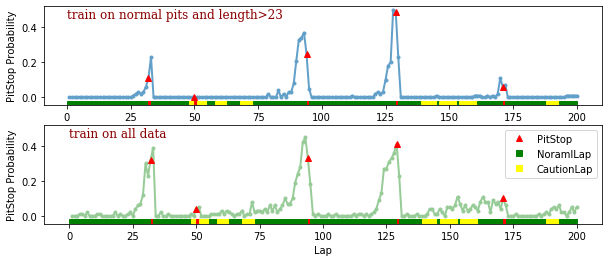

In [161]:
#red = '#ff8080'
red = 'red'
#yellow = '#8080ff'
yellow = 'yellow'
#green = '#80ff80'
green = 'green'

light_blue = '#62a0ca'
light_green = '#97cb97'
light_magenta = '#e597e5'

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 12,
        }

def add_status(axs,y=-0.04, height=0.02):
    for lap in range(200):
        fc = green
        if caution[lap] == 1:
            fc = yellow
        if pitstop[lap] == 1:
            fc = red
        ec = fc
        rectangle = plt.Rectangle((lap,y), 1, height, fc=fc,ec=ec)
        #plt.gca().add_patch(rectangle)
        axs.add_patch(rectangle)

lw=2
        
fig, axs = plt.subplots(2, 1, figsize=(10, 4))

rid = 'sel'
axs[0].plot(prob[rid][0,:],prob[rid][1,:],'.-',color=light_blue ,label='', linewidth=lw)
axs[0].plot(pit[rid][0,:],pit[rid][1,:],'^',color='r', label='PitStop', linewidth=lw)
axs[0].set_ylabel('PitStop Probability')
axs[0].set_xlabel('Lap')
add_status(axs[0])
axs[0].set_ylim((-0.045,0.52))
axs[0].text(0,0.45, 'train on normal pits and length>23',fontdict=font)

rid = 'all'
axs[1].plot(prob[rid][0,:],prob[rid][1,:],'.-',color=light_green,label='', linewidth=lw)
axs[1].plot(pit[rid][0,:],pit[rid][1,:],'^',color='r', label='PitStop', linewidth=lw)
axs[1].set_ylabel('PitStop Probability')
axs[1].set_xlabel('Lap')
add_status(axs[1])
axs[1].set_ylim((-0.045,0.52))
axs[1].text(0,0.45, 'train on all data',fontdict=font)


axs[1].plot([0],[-10],'s',color=green, label='NoramlLap', linewidth=lw)
axs[1].plot([0],[-10],'s',color=yellow, label='CautionLap', linewidth=lw)
plt.legend(prop={'size': 10})
plt.savefig('probility_output_pitmodel.pdf')

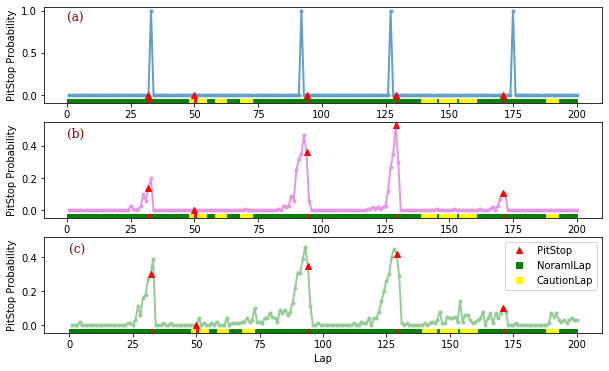

In [456]:
#red = '#ff8080'
red = 'red'
#yellow = '#8080ff'
yellow = 'yellow'
#green = '#80ff80'
green = 'green'

light_blue = '#62a0ca'
light_green = '#97cb97'
light_magenta = '#e597e5'

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 12,
        }

def add_status(axs,y=-0.04, height=0.02):
    for lap in range(200):
        fc = green
        if caution[lap] == 1:
            fc = yellow
        if pitstop[lap] == 1:
            fc = red
        ec = fc
        rectangle = plt.Rectangle((lap,y), 1, height, fc=fc,ec=ec)
        #plt.gca().add_patch(rectangle)
        axs.add_patch(rectangle)

lw=2
        
fig, axs = plt.subplots(3, 1, figsize=(10, 6))

rid = 'dsel'
axs[0].plot(prob[rid][0,:],prob[rid][1,:],'.-',color=light_blue ,label='', linewidth=lw)
axs[0].plot(pit[rid][0,:],pit[rid][1,:],'^',color='r', label='PitStop', linewidth=lw)
axs[0].set_ylabel('PitStop Probability')
axs[0].set_xlabel('Lap')
add_status(axs[0], y=-0.08, height=0.035)
axs[0].set_ylim((-0.045*2,1.05))
#axs[0].text(0,0.9, 'w/o uncertainty\ntrain on long normal pits',fontdict=font)
axs[0].text(0,0.87, '(a)',fontdict=font)


rid = 'sel'
axs[1].plot(prob[rid][0,:],prob[rid][1,:],'.-',color=light_magenta ,label='', linewidth=lw)
axs[1].plot(pit[rid][0,:],pit[rid][1,:],'^',color='r', label='PitStop', linewidth=lw)
axs[1].set_ylabel('PitStop Probability')
axs[1].set_xlabel('Lap')
add_status(axs[1])
axs[1].set_ylim((-0.045,0.55))
#axs[1].text(0,0.45, 'with uncertainty\ntrain on long normal pits',fontdict=font)
axs[1].text(0,0.45, '(b)',fontdict=font)

rid = 'all'
axs[2].plot(prob[rid][0,:],prob[rid][1,:],'.-',color=light_green,label='', linewidth=lw)
axs[2].plot(pit[rid][0,:],pit[rid][1,:],'^',color='r', label='PitStop', linewidth=lw)
axs[2].set_ylabel('PitStop Probability')
axs[2].set_xlabel('Lap')
add_status(axs[2])
axs[2].set_ylim((-0.045,0.52))
#axs[2].text(0,0.45, 'with uncertainty\ntrain on full dataset',fontdict=font)
axs[2].text(0,0.42, '(c)',fontdict=font)


axs[2].plot([0],[-10],'s',color=green, label='NoramlLap', linewidth=lw)
axs[2].plot([0],[-10],'s',color=yellow, label='CautionLap', linewidth=lw)
plt.legend(prop={'size': 10})
plt.savefig('probility_output_pitmodel.pdf')

## raw long prediction

In [166]:
pitmodel = PitModel()
#pitmodel.load_model('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
#pitmodel.load_model('pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
pitmodel.load_model('pitmodel-m65-mlp-dnoshort-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
test_car12 = df_test[df_test['carno']==12]
test_ds = test_car12[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

forecast,targets = pitmodel.forecast_onecar_lap2nextpit(test_ds)

init model:pitmodel-m65-mlp-dnoshort-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle


In [175]:
#fill template
targets[np.where(targets==999)] = 0
tss = tss_template.copy()
for idx in range(len(tss)):
    if idx < len(targets):
        tss.iloc[idx, 0] = targets[idx]
    else:
        tss.iloc[idx, 0] = 0

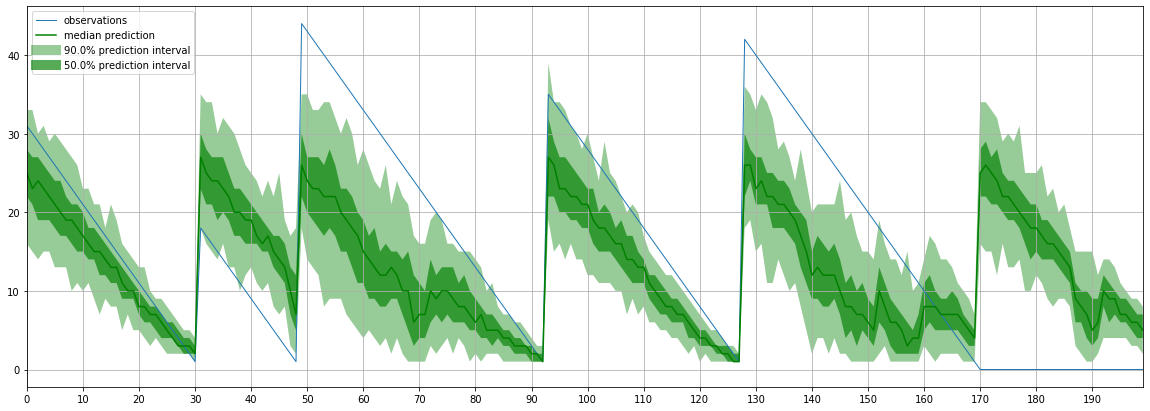

In [176]:
plot_prob_forecasts_ex([tss],[forecast],'')

In [174]:
targets[:-10]

array([ 31.,  30.,  29.,  28.,  27.,  26.,  25.,  24.,  23.,  22.,  21.,
        20.,  19.,  18.,  17.,  16.,  15.,  14.,  13.,  12.,  11.,  10.,
         9.,   8.,   7.,   6.,   5.,   4.,   3.,   2.,   1.,  18.,  17.,
        16.,  15.,  14.,  13.,  12.,  11.,  10.,   9.,   8.,   7.,   6.,
         5.,   4.,   3.,   2.,   1.,  44.,  43.,  42.,  41.,  40.,  39.,
        38.,  37.,  36.,  35.,  34.,  33.,  32.,  31.,  30.,  29.,  28.,
        27.,  26.,  25.,  24.,  23.,  22.,  21.,  20.,  19.,  18.,  17.,
        16.,  15.,  14.,  13.,  12.,  11.,  10.,   9.,   8.,   7.,   6.,
         5.,   4.,   3.,   2.,   1.,  35.,  34.,  33.,  32.,  31.,  30.,
        29.,  28.,  27.,  26.,  25.,  24.,  23.,  22.,  21.,  20.,  19.,
        18.,  17.,  16.,  15.,  14.,  13.,  12.,  11.,  10.,   9.,   8.,
         7.,   6.,   5.,   4.,   3.,   2.,   1.,  42.,  41.,  40.,  39.,
        38.,  37.,  36.,  35.,  34.,  33.,  32.,  31.,  30.,  29.,  28.,
        27.,  26.,  25.,  24.,  23.,  22.,  21.,  2

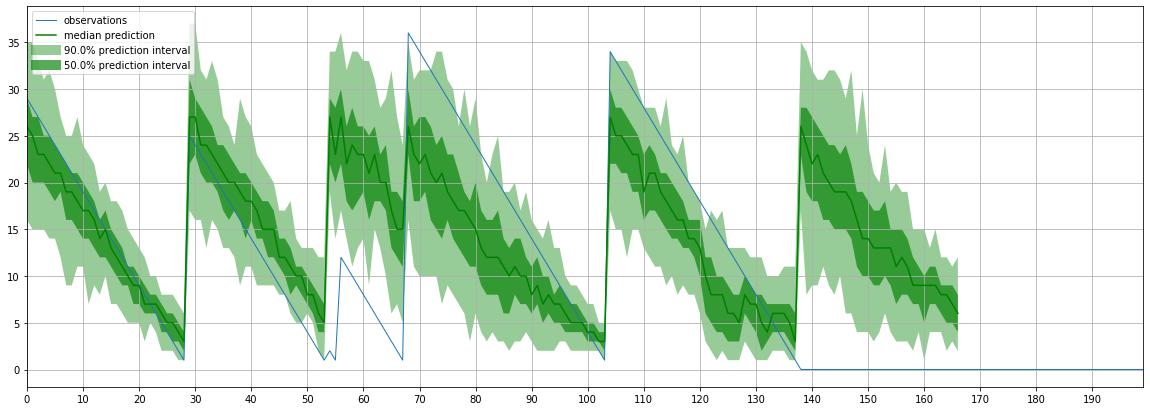

In [178]:
# check car12 in indy500-2017
test_car12 = df_train[(df_train['carno']==12) & (df_train['eid']==4)]
test_ds = test_car12[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
forecast,targets = pitmodel.forecast_onecar_lap2nextpit(test_ds)
#fill template
targets[np.where(targets==999)] = 0
tss = tss_template.copy()
for idx in range(len(tss)):
    if idx < len(targets):
        tss.iloc[idx, 0] = targets[idx]
    else:
        tss.iloc[idx, 0] = 0
plot_prob_forecasts_ex([tss],[forecast],'')        

In [180]:
test_car12[(test_car12['lap']>50) & (test_car12['lap']<60)]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
24516,3.0,0.0,22.0,1.0,12,4,51,25.0,0.0
24517,2.0,1.0,23.0,1.0,12,4,52,25.0,1.0
24518,1.0,2.0,24.0,1.0,12,4,53,25.0,2.0
24519,2.0,0.0,0.0,1.0,12,4,54,2.0,0.0
24520,1.0,1.0,1.0,1.0,12,4,55,2.0,1.0
24521,12.0,0.0,0.0,1.0,12,4,56,12.0,0.0
24522,11.0,1.0,1.0,1.0,12,4,57,12.0,1.0
24523,10.0,2.0,2.0,1.0,12,4,58,12.0,2.0
24524,9.0,2.0,3.0,1.0,12,4,59,12.0,0.0


init model:pitmodel-m65-dmlp-dnoshort-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR:

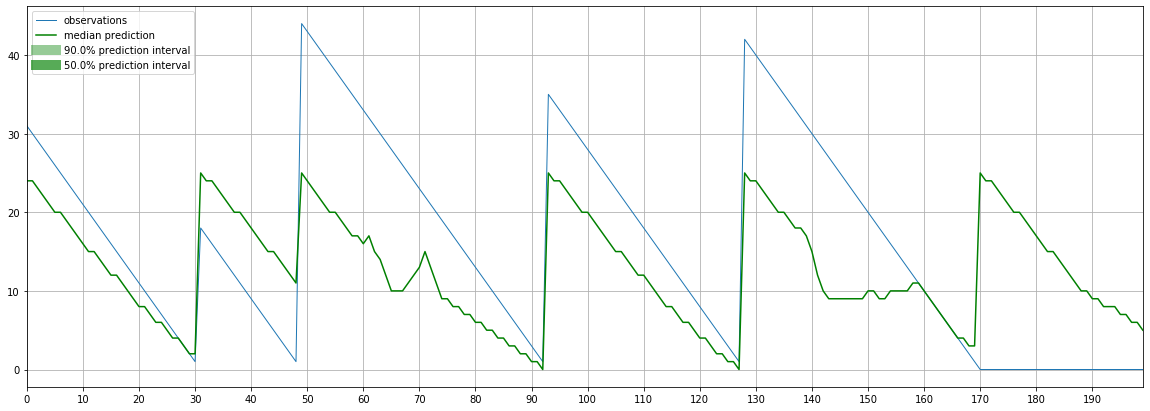

In [254]:
pitmodel = PitModel()
#pitmodel.load_model('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
#pitmodel.load_model('pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
pitmodel.load_model('pitmodel-m65-dmlp-dnoshort-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle')
# check car12 in indy500-2017
test_car12 = df_test[df_test['carno']==12]
test_ds = test_car12[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

forecast,targets = pitmodel.forecast_onecar_lap2nextpit(test_ds[:,:3])
#fill template
targets[np.where(targets==999)] = 0
tss = tss_template.copy()
for idx in range(len(tss)):
    if idx < len(targets):
        tss.iloc[idx, 0] = targets[idx]
    else:
        tss.iloc[idx, 0] = 0
plot_prob_forecasts_ex([tss],[forecast],'')    

## draw histgram of forecasting result

In [283]:
def draw_hist(forecast, targets, maxlap=200):
    
    histsum = np.zeros((maxlap))
    
    samples = forecast.samples
    print('sample shape:', samples.shape)
    
    samplecnt , totallap = samples.shape

    if totallap == maxlap:
        last_pitlap = np.where(targets == 999)[0][0]
        print('last pitlap:', last_pitlap)
    else:
        last_pitlap = totallap
    
    for lap in range(last_pitlap):
        pitlap_pred = lap + samples[:, lap]
        pitlap_idx = pitlap_pred.astype(int)
        
        #histsum[pitlap_idx] += 1
        for idx in pitlap_idx:
            if idx < maxlap:
                histsum[idx] += 1
    
    #normalize
    histsum /= samplecnt*totallap
    
    return histsum

In [264]:
pitmodel.load_model('pitmodel-m65-dmlp-dnoshort-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle')
forecast,targets = pitmodel.forecast_onecar_lap2nextpit(test_ds[:,:3])

init model:pitmodel-m65-dmlp-dnoshort-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR:

In [265]:
h = draw_hist(forecast, targets)

sample shape: (100, 200)
last pitlap: 170


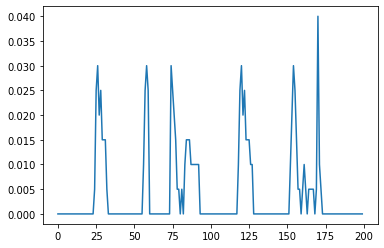

In [266]:
plt.plot(h)

init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
sample shape: (100, 200)
last pitlap: 170


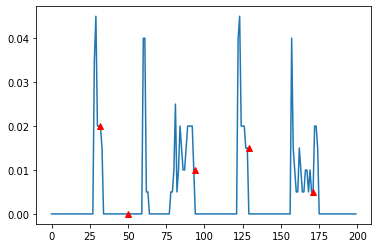

In [280]:
rid='sel'
pitmodel.load_model('pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle')
forecast,targets = pitmodel.forecast_onecar_lap2nextpit(test_ds[:,:3])
h = draw_hist(forecast, targets)
plt.plot(h)

x= pit[rid][0,:].astype(int)
y = h[x-1]
plt.plot(x,y,'^',color='r', label='PitStop', linewidth=lw)

init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
sample shape: (100, 200)
last pitlap: 170


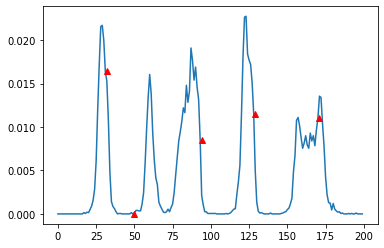

In [277]:
rid='sel'
pitmodel.load_model(f'pitmodel-m65-mlp-d{rid}-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
forecast2,targets2 = pitmodel.forecast_onecar_lap2nextpit(test_ds)
h2 = draw_hist(forecast2, targets2)
plt.plot(h2)

x= pit[rid][0,:].astype(int)
y = h2[x-1]
plt.plot(x,y,'^',color='r', label='PitStop', linewidth=lw)

In [275]:
pit[rid][0,:].astype(int)

array([ 32,  50,  94, 129, 171])

In [289]:
test_plen2 = df_test[(df_test['lap2nextpit']==2)]
test_ds = test_plen2[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

test_car12 = df_test[(df_test['carno']==12) & (df_test['lap2nextpit']==2)]
test_ds = test_car12[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
sample shape: (100, 5)


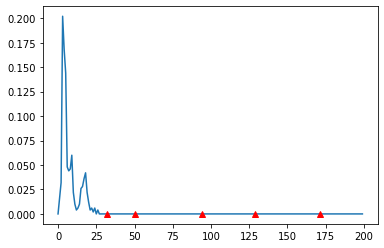

In [290]:
rid='sel'
pitmodel.load_model(f'pitmodel-m65-mlp-d{rid}-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
forecast2,targets2 = pitmodel.forecast_onecar_lap2nextpit(test_ds)
h2 = draw_hist(forecast2, targets2)
plt.plot(h2)

x= pit[rid][0,:].astype(int)
y = h2[x-1]
plt.plot(x,y,'^',color='r', label='PitStop', linewidth=lw)

init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-nocurcautionlaps.pickle
sample shape: (100, 5)


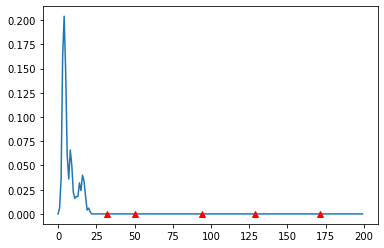

In [292]:
rid='sel'
pitmodel.load_model(f'pitmodel-m65-mlp-d{rid}-e500-l10-10-5-student-d0.1-1k-nocurcautionlaps.pickle')
forecast2,targets2 = pitmodel.forecast_onecar_lap2nextpit(test_ds)
h2 = draw_hist(forecast2, targets2)
plt.plot(h2)

x= pit[rid][0,:].astype(int)
y = h2[x-1]
plt.plot(x,y,'^',color='r', label='PitStop', linewidth=lw)

init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
sample shape: (100, 5)


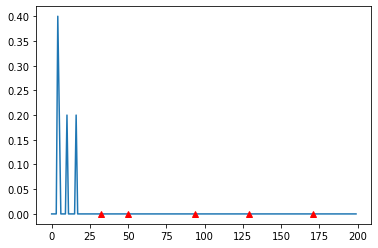

In [291]:
pitmodel.load_model('pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle')
forecast,targets = pitmodel.forecast_onecar_lap2nextpit(test_ds[:,:3])
h = draw_hist(forecast, targets)
plt.plot(h)

x= pit[rid][0,:].astype(int)
y = h[x-1]
plt.plot(x,y,'^',color='r', label='PitStop', linewidth=lw)

## test

In [101]:
prob['noshort'][0,:]

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15

In [78]:
pitmodel = PitModel()
#pitmodel.load_model('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
#pitmodel.load_model('pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
pitmodel.load_model('pitmodel-m65-mlp-dnoshort-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
test_car12 = df_test[df_test['carno']==12]
test_ds = test_car12[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

forecast,targets = pitmodel.forecast_onecar(test_ds)



init model:pitmodel-m65-mlp-dnoshort-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle


In [79]:
pitidx = np.where(targets==1)
pits = targets[pitidx]

In [80]:
#fill template
tss = tss_template.copy()
for idx in range(len(tss)):
    if idx < len(targets):
        tss.iloc[idx, 0] = targets[idx]
    else:
        tss.iloc[idx, 0] = 0


In [81]:
tss.iloc[31,0]

1.0

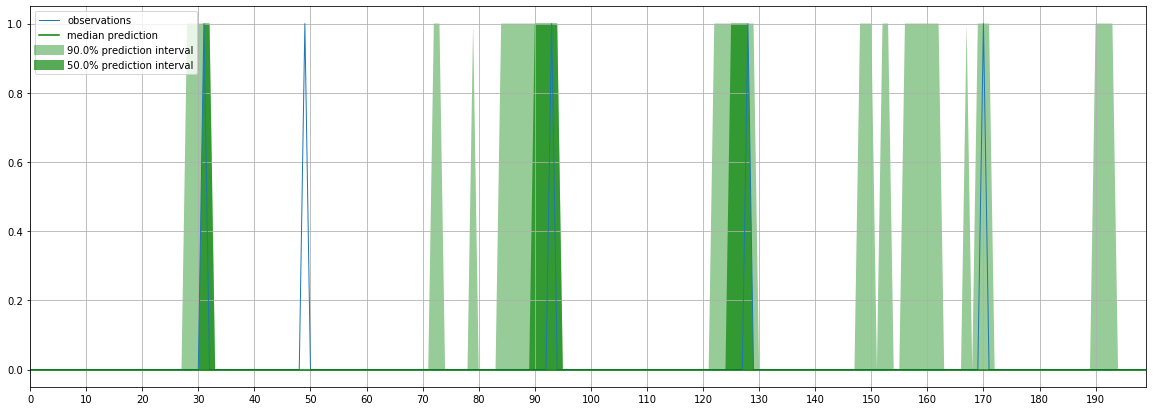

In [82]:
plot_prob_forecasts_ex([tss],[forecast],'')

In [83]:
pred = np.mean(forecast.samples, axis=0)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.03, 0.01, 0.  , 0.  ,
       0.01, 0.  , 0.02, 0.01, 0.04, 0.04, 0.15, 0.23, 0.22, 0.3 , 0.32,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.01, 0.  , 0.02, 0.03, 0.03, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.01,
       0.02, 0.01, 0.03, 0.03, 0.05, 0.05, 0.1 , 0.11, 0.02, 0.05, 0.05,
       0.01, 0.01, 0.1 , 0.05, 0.01, 0.01, 0.04, 0.06, 0.12, 0.14, 0.09,
       0.2 , 0.25, 0.26, 0.27, 0.3 , 0.29, 0.33, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.01, 0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.03, 0.01, 0.04, 0.03,
       0.04, 0.17, 0.14, 0.24, 0.38, 0.33, 0.41, 0.47, 0.2 , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.02,
       0.  , 0.04, 0.01, 0.01, 0.03, 0.06, 0.1 , 0.

Text(0.5, 0, 'Lap')

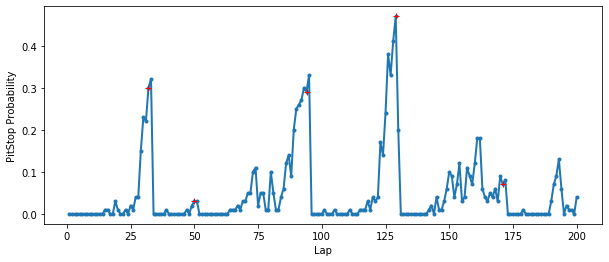

In [86]:
fig, axs = plt.subplots(1, 1, figsize=(10, 4))
#axs.plot(data[:,0],data[:,1],'.-',label='RANK', linewidth=2)
#axs.plot(cautions[:,0],cautions[:,1],'.',color='y', label='CautionLap', linewidth=2)
#axs.plot(pits[:,0],pits[:,1],'+',color='r', label='PitStop', linewidth=2)
x = np.arange(len(pred)) + 1
axs.plot(x, pred,'.-',label='PitStop', linewidth=2)

x = pitidx[0].reshape(-1)
y = np.zeros_like(x)
y = pred[x]
#axs.scatter(x,y,color='r')
#,'+',color='r', label='PitStopX')
axs.plot(x+1,y,'+',color='r', label='PitStopX', linewidth=2)
axs.set_ylabel('PitStop Probability')
axs.set_xlabel('Lap')

In [78]:
x.shape

(5,)

In [80]:
y.shape

(5,)

In [69]:
pitidx[0]

array([ 31,  49,  93, 128, 170])

In [196]:
test_car12[(test_car12['lap']>24) & (test_car12['lap']<33)]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
24490,4.0,0.0,26.0,0.0,12,4,25,29.0,0.0
24491,3.0,0.0,27.0,0.0,12,4,26,29.0,0.0
24492,2.0,0.0,28.0,0.0,12,4,27,29.0,0.0
24493,1.0,0.0,29.0,0.0,12,4,28,29.0,0.0
24494,25.0,0.0,0.0,1.0,12,4,29,25.0,0.0
24495,24.0,0.0,1.0,1.0,12,4,30,25.0,0.0
24496,23.0,0.0,2.0,1.0,12,4,31,25.0,0.0
24497,22.0,0.0,3.0,1.0,12,4,32,25.0,0.0


In [103]:
test_car12[(test_car12['lap']>45) & (test_car12['lap']<53)]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
1227,3.0,0.0,15.0,1.0,12,5,46,18.0,0.0
1228,2.0,1.0,16.0,1.0,12,5,47,18.0,1.0
1229,1.0,2.0,17.0,1.0,12,5,48,18.0,2.0
1230,44.0,0.0,0.0,0.0,12,5,49,44.0,0.0
1231,43.0,1.0,1.0,0.0,12,5,50,44.0,1.0
1232,42.0,2.0,2.0,0.0,12,5,51,44.0,2.0
1233,41.0,3.0,3.0,0.0,12,5,52,44.0,3.0


In [37]:
pred[45:55]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [63]:
pred.shape

(202,)

In [64]:
test_ds

array([[31.,  0.,  1.,  0.],
       [30.,  0.,  2.,  0.],
       [29.,  0.,  3.,  0.],
       [28.,  0.,  4.,  0.],
       [27.,  0.,  5.,  0.],
       [26.,  0.,  6.,  0.],
       [25.,  0.,  7.,  0.],
       [24.,  0.,  8.,  0.],
       [23.,  0.,  9.,  0.],
       [22.,  0., 10.,  0.],
       [21.,  0., 11.,  0.],
       [20.,  0., 12.,  0.],
       [19.,  0., 13.,  0.],
       [18.,  0., 14.,  0.],
       [17.,  0., 15.,  0.],
       [16.,  0., 16.,  0.],
       [15.,  0., 17.,  0.],
       [14.,  0., 18.,  0.],
       [13.,  0., 19.,  0.],
       [12.,  0., 20.,  0.],
       [11.,  0., 21.,  0.],
       [10.,  0., 22.,  0.],
       [ 9.,  0., 23.,  0.],
       [ 8.,  0., 24.,  0.],
       [ 7.,  0., 25.,  0.],
       [ 6.,  0., 26.,  0.],
       [ 5.,  0., 27.,  0.],
       [ 4.,  0., 28.,  0.],
       [ 3.,  0., 29.,  0.],
       [ 2.,  0., 30.,  0.],
       [ 1.,  0., 31.,  0.],
       [18.,  0.,  0.,  0.],
       [17.,  0.,  1.,  0.],
       [16.,  0.,  2.,  0.],
       [15.,  

In [107]:
model['sel'].predict(1,16,1)

15.0

In [117]:
def testmodel(rid):
    pitmodel = model[rid]
    samples = np.zeros((1000))
    for i in range(1000):
        samples[i] = pitmodel.predict(1,16,1)

    print('min:', np.min(samples))
    print('<5:', np.sum(samples<=5))
    print('prob(plen=2) = ', np.sum(samples==2)/1000)
    return samples

In [118]:
s = testmodel('sel')

min: 3.0
<5: 4
prob(plen=2) =  0.0


In [119]:
s = testmodel('all')

min: 1.0
<5: 157
prob(plen=2) =  0.025


In [120]:
s = testmodel('noshort')

min: 1.0
<5: 148
prob(plen=2) =  0.017


In [426]:
df_test[df_test['pit_oncaution']==0]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
0,31.0,0.0,1.0,0.0,1,5,0,31.0,0.0
1,30.0,0.0,2.0,0.0,1,5,1,31.0,0.0
2,29.0,0.0,3.0,0.0,1,5,2,31.0,0.0
3,28.0,0.0,4.0,0.0,1,5,3,31.0,0.0
4,27.0,0.0,5.0,0.0,1,5,4,31.0,0.0
...,...,...,...,...,...,...,...,...,...
5566,999.0,5.0,26.0,0.0,98,5,195,0.0,0.0
5567,999.0,5.0,27.0,0.0,98,5,196,0.0,0.0
5568,999.0,5.0,28.0,0.0,98,5,197,0.0,0.0
5569,999.0,5.0,29.0,0.0,98,5,198,0.0,0.0


In [427]:
df_test[df_test['pit_oncaution']==1]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
31,18.0,0.0,0.0,1.0,1,5,31,18.0,0.0
32,17.0,0.0,1.0,1.0,1,5,32,18.0,0.0
33,16.0,0.0,2.0,1.0,1,5,33,18.0,0.0
34,15.0,0.0,3.0,1.0,1,5,34,18.0,0.0
35,14.0,0.0,4.0,1.0,1,5,35,18.0,0.0
...,...,...,...,...,...,...,...,...,...
5415,5.0,0.0,13.0,1.0,98,5,44,18.0,0.0
5416,4.0,0.0,14.0,1.0,98,5,45,18.0,0.0
5417,3.0,1.0,15.0,1.0,98,5,46,18.0,1.0
5418,2.0,2.0,16.0,1.0,98,5,47,18.0,2.0


In [428]:
len(df_test[(df_test['pit_oncaution']==0) & (df_test['lap2nextpit']==1)])

108

In [429]:
len(df_test[(df_test['pit_oncaution']==1) & (df_test['lap2nextpit']==1)])

69

In [435]:
len(df_test[(df_test['pit_oncaution']==0) & (df_test['lap2nextpit']==1) &(df_test['stint_len']>23)])

102

In [436]:
len(df_test[(df_test['pit_oncaution']==0) &(df_test['stint_len']>23)])

3638

In [445]:
for feature_cnt in [2]:
    for datamode in ['shortnormal']:
        #paper output
        rdata, ret = get_macro_eval(f'pitmodel-m65-mlp-dsel-f{feature_cnt}-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle', 
                                feature_cnt, plen=plen, threshold=threshold, datamode = datamode)
        
        
        #reteval.append(['mlp-sel',feature_cnt,datamode, plen, ret[0], ret[1]])


init model:pitmodel-m65-mlp-dsel-f2-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[ 7 18 31]
f1: 0.0 recall 0.0
[35, 36, 37, 38, 39, 40]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[8]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[32, 33, 34, 35]
[]
f1: 0.0 recall 0.0
[35, 36, 37, 38, 39, 40, 41, 42, 43]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[2]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
[]
[]
f1: 0.0 recall 0.0
macro ret: [0. 0.]
